# Sentimen Analysis tentang penundaan Pemilu di Twitter

# Load library

In [221]:
import re
import string
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from unidecode import unidecode
from tqdm import tqdm
from wordcloud.wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import StandardScaler

from IPython.display import display
from IPython.core.display import HTML

In [222]:
def print_df(df):
    return display(HTML(df.to_html().replace("\\n","<br>")))

def print_cv_result(cv_result):
    columns = ['params', 'mean_fit_time', 'std_fit_time', 'mean_test_score', 'std_test_score', 'rank_test_score']
    return print_df(pd.DataFrame(cv_result)[columns].sort_values(by='rank_test_score'))

# Load dataset twit "Penundaan Pemilu"

In [223]:
df = pd.read_csv('https://raw.githubusercontent.com/bramaningds/datasets/main/tweet-penundaan-pemilu.csv')

## Overview

In [224]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3441 entries, 0 to 3440
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      3441 non-null   int64 
 1   screenname      3439 non-null   object
 2   username        3441 non-null   object
 3   datetime        3441 non-null   object
 4   url             3441 non-null   object
 5   tweetText       3441 non-null   object
 6   source_domain   974 non-null    object
 7   source_title    974 non-null    object
 8   source_snippet  870 non-null    object
 9   replies_count   3422 non-null   object
 10  retweets_count  2520 non-null   object
 11  likes_count     3027 non-null   object
 12  views_count     3243 non-null   object
 13  reply_to        954 non-null    object
dtypes: int64(1), object(13)
memory usage: 376.5+ KB


## Duplicated values

In [225]:
df.nunique().sort_values(ascending=False)

Unnamed: 0        3441
url               1497
datetime          1496
tweetText         1453
views_count       1019
username           785
screenname         784
source_title       352
source_snippet     342
likes_count        300
reply_to           269
retweets_count     191
replies_count      136
source_domain       64
dtype: int64

`url` field should be unique, will drop later

## Missing value

In [226]:
df.drop_duplicates(subset='url').isna().sum().sort_values(ascending=False)

source_snippet    1115
reply_to          1084
source_domain     1072
source_title      1072
retweets_count     387
likes_count        165
views_count        107
replies_count       11
screenname           1
Unnamed: 0           0
username             0
datetime             0
url                  0
tweetText            0
dtype: int64

High missing values on `reply_to` indicates most tweets are personal opinion, not a reply tweet

Missing values on three columns `source_snippet`, `source_domain`, `source_title` also confirms most tweets are personal opinion, not shared from external source

In [227]:
print('Total unique tweet is', df.drop_duplicates(subset='url').shape[0])
print('Total empty tweet that not "shared tweet" is ', df.drop_duplicates(subset='url').loc[df['tweetText'].isna() & df['source_domain'].isna()].shape[0])

Total unique tweet is 1497
Total empty tweet that not "shared tweet" is  0


Will drop blank tweet (empty `tweetText` and empty `source_domain`)

In [228]:
print('Minimum date:', pd.to_datetime(df['datetime']).dt.tz_convert('Asia/Jakarta').min())
print('Maximum date:', pd.to_datetime(df['datetime']).dt.tz_convert('Asia/Jakarta').max())

Minimum date: 2022-12-10 20:47:23+07:00
Maximum date: 2023-05-30 01:24:01+07:00


Will only retain relevant data with the issue

In [229]:
df.assign(date=pd.to_datetime(df.datetime).dt.date).groupby(by='date').agg(tweet=('url', 'nunique')).idxmax()

tweet    2023-03-03
dtype: object

The peak is at 2023-03-03, so we will retain most relevant dates

# Preprocessing

## Download slang word dictionary

In [230]:
# Download slang word dictionary
slang_formal = pd.read_csv('https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv')[['slang','formal']].values
# Make dictionary object
slang_formal_dictionary = {words[0]:words[1] for words in slang_formal}
# Add custom vocab
slang_formal_dictionary.update({
    'petcah': 'pecah',
    'hkm': 'hukum',
    'bpk': 'bapak'
})

## Define text preprocessor functions

In [231]:
# get all urls from sentece
def extract_urls(text):
    groups = re.findall(r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))", text)
    urls = [group[0] for group in groups if len(group) > 0]
    return urls if len(urls) > 0 else None

# remove urls from sentence
def remove_urls(text):
    return re.sub(r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))", ' ', text)

# get all hashtag from sentence
def extract_hashtags(text):
    hashtags = re.findall(r'#[^ #]+', text)
    hashtags = [re.sub(r'[^#\w\d]', '', hashtag) for hashtag in hashtags if len(hashtag) > 0]
    return hashtags if len(hashtags) > 0 else None

# remove hashtags from sentence
def remove_hashtags(text):
    return re.sub(r'#[^ #]+', ' ', text)

# get all mentions from sentence
def extract_mentions(text):
    mentions = re.findall(r'@[^ @]+', text)
    mentions = [re.sub(r'[^@\w\d]', '', mention) for mention in mentions if len(mention) > 0]
    return mentions if len(mentions) > 0 else None

# remove mentions from sentence
def remove_mentions(text):
    return re.sub(r'@[^ @]+', ' ', text)

# remove all numbers except year pattern
def remove_number_except_year(text):
    return re.sub(r'\b(?!19[4-9]\d|20[0-3]\d|2040)\d+\b', ' ', text)

# remove all punctuantions
def remove_punctuantion(text):
    return re.sub(f'[{string.punctuation}…]+', ' ', text)

# remove multi spaces from sentence
def remove_multispace(text):
    return re.sub(r'\s+', ' ', text)

# make replacement for slang words from sentence
def normalize_slang_word(sentence):
    return ' '.join([slang_formal_dictionary.get(word, word) for word in sentence.split()])

# make vocab word frequency
def make_words_frequency_1(corpus):
    cv = CountVectorizer(ngram_range=(1,1))
    freqs = cv.fit_transform(corpus).sum(axis=0)
    tokens = cv.get_feature_names_out()
    words_freq = {tokens[i]:freqs[0, i] for i in range(len(tokens))}
    return {k: v for k, v in sorted(words_freq.items(), key=lambda item: item[1], reverse=True)}

def make_words_frequency_2(corpus, stopwords=['pemilu', 'penundaan', 'ditunda']):
    cv = CountVectorizer(ngram_range=(2,2), stop_words=stopwords)
    freqs = cv.fit_transform(corpus).sum(axis=0)
    tokens = cv.get_feature_names_out()
    words_freq = {tokens[i]:freqs[0, i] for i in range(len(tokens))}
    return {k: v for k, v in sorted(words_freq.items(), key=lambda item: item[1], reverse=True)}

def make_words_frequency_3(corpus, stopwords=[]):
    cv = CountVectorizer(ngram_range=(3,3), stop_words=['pemilu', 'penundaan', 'ditunda'])
    freqs = cv.fit_transform(corpus).sum(axis=0)
    tokens = cv.get_feature_names_out()
    words_freq = {tokens[i]:freqs[0, i] for i in range(len(tokens))}
    return {k: v for k, v in sorted(words_freq.items(), key=lambda item: item[1], reverse=True)}

## Apply data preprocessing

In [232]:
# drop duplicated tweet (keep duplicated content)
df.drop_duplicates(subset='url', inplace=True)

# set `tweetText` with title of external source
df.loc[df['tweetText'].isna(), 'tweetText'] = df.loc[df['tweetText'].isna(), 'source_title']

# drop blank tweet
df.dropna(subset='tweetText', inplace=True)

# convert `datetime` to datetime object
df['datetime'] = pd.to_datetime(df['datetime']).dt.tz_convert('Asia/Jakarta')

# create `date` field to do grouping task later
df['date'] = df['datetime'].dt.date

# create `month` field to do grouping task later
df['month'] = df['datetime'].dt.month

# create `hour` field to do grouping task later
df['hour'] = df['datetime'].dt.hour

# retain data with range in 
df = df[(df['datetime'] >= '2023-02-01') & (df['datetime'] < '2023-04-01')]

# drop `screenname` field, use `username` instead
df.drop(columns='screenname', inplace=True)

# convert *count field to numeric
def to_numeric(value):
    if value == '':
        return 0

    value = str(value).replace(',','')
    number = re.findall(r'[\d.]+', value)[0]

    if value.find('K') > 0:
        return int(float(number) * 1000)
    elif value.find('M') > 0:
        return int(float(number) * 1000000)
    else:
        return int(float(number))

df['replies_count'] = df['replies_count'].fillna('0').apply(to_numeric).astype(int)
df['retweets_count'] = df['retweets_count'].fillna('0').apply(to_numeric).astype(int)
df['likes_count'] = df['likes_count'].fillna('0').apply(to_numeric).astype(int)
df['views_count'] = df['views_count'].fillna('0').apply(to_numeric).astype(int)

# define engagement value column (reply + retweet + like)
df['engagement'] = df['replies_count'] + df['retweets_count'] + df['likes_count']

# define if the tweet is shared
df['is_shared'] = df['source_domain'].isna() == False

# define if the tweet is a repliy from another tweet
df['is_reply'] = df['reply_to'].isna() == False

# rename columns to simplify
dict_columns = {
    'replies_count' : 'reply', 
    'retweets_count': 'retweet', 
    'likes_count'   : 'like', 
    'views_count'   : 'view', 
    'tweetText'     : 'text'
}
df.rename(columns=dict_columns, inplace=True)

# drop external source
df.drop(columns=['source_domain', 'source_title', 'source_snippet'])

# keep original tweet text
df['original_text'] = df['text']

# urls extraction
df['link'] = df['text'].apply(extract_urls)

# hashtags extraction
df['hashtag'] = df['text'].apply(extract_hashtags)

# mentions extraction
df['mention'] = df['text'].apply(extract_mentions)

# preprocess the text
df['text'] = (df['text'].apply(remove_urls)
                        .apply(remove_hashtags)
                        .apply(remove_mentions)
                        .apply(remove_number_except_year)
                        .apply(remove_punctuantion)
                        .apply(str.lower)
                        .apply(unidecode)
                        .apply(remove_multispace)
                        .apply(normalize_slang_word))

# rearrange the columns
df = df[[
    'url', 'datetime', 'date', 'hour', 'username', 
    'text', 'hashtag', 'mention', 'original_text',
    'engagement', 'reply', 'retweet', 'like', 'view',
    'is_reply', 'reply_to', 'is_shared'
]]

# add tweet length feature
df['length'] = df['text'].str.len()

# sort tweet by datetime
df.sort_values(by='date', inplace=True)

# reset index
df.reset_index(drop=True, inplace=True)

## Preprocessing result

In [233]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028 entries, 0 to 1027
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype                       
---  ------         --------------  -----                       
 0   url            1028 non-null   object                      
 1   datetime       1028 non-null   datetime64[ns, Asia/Jakarta]
 2   date           1028 non-null   object                      
 3   hour           1028 non-null   int32                       
 4   username       1028 non-null   object                      
 5   text           1028 non-null   object                      
 6   hashtag        122 non-null    object                      
 7   mention        105 non-null    object                      
 8   original_text  1028 non-null   object                      
 9   engagement     1028 non-null   int32                       
 10  reply          1028 non-null   int32                       
 11  retweet        1028 non-null   int32       

# Exploratory Data Analysis

## Timeline

<Axes: title={'center': 'Number of tweets timeline'}, xlabel='date'>

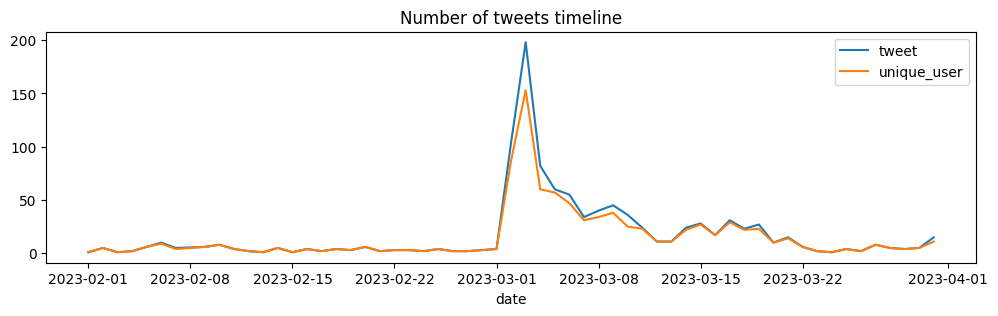

In [234]:
(df.groupby(by='date')
   .agg(tweet=('url', 'size'), unique_user=('username', 'nunique'))
   .plot(kind='line', figsize=(12,3), title="Number of tweets timeline"))

<Axes: title={'center': 'Number of engagement timeline'}, xlabel='date'>

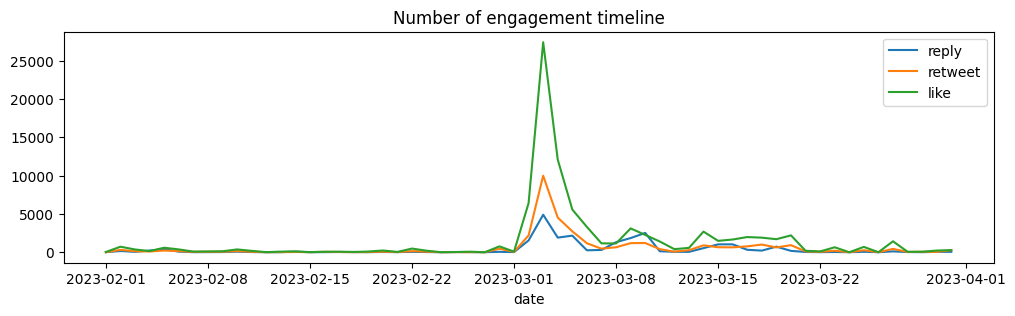

In [235]:
(df.groupby(by='date')
   .agg(reply=('reply', 'sum'), 
        retweet=('retweet', 'sum'),
        like=('like', 'sum'))
   .plot(kind='line',
         figsize=(12,3),
         title="Number of engagement timeline"))

In [236]:
peak_date = df['date'] == df.groupby(by='date').size().idxmax()

In [237]:
print('Total tweet at peak date', df[peak_date].shape[0])
print(
    'Unique user at peak date', 
    df[peak_date]['username'].nunique(), 'users or',
    100 * df[peak_date]['username'].nunique() / df[peak_date].shape[0], '%'
)

Total tweet at peak date 198
Unique user at peak date 153 users or 77.27272727272727 %


## Most active user

<Axes: title={'center': 'Most active account'}, ylabel='username'>

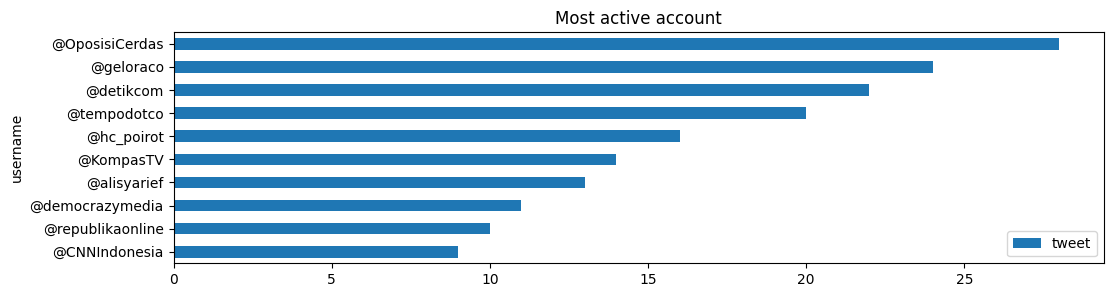

In [238]:
(df.groupby(by='username')
   .agg(tweet=('url', 'size'))
   .sort_values(by='tweet', ascending=False)
   .head(10)
   .sort_values(by='tweet', ascending=True)
   .plot(kind='barh',
         title="Most active account",
         figsize=(12,3)))

<Axes: title={'center': 'Most active account at 2023-03-03'}, ylabel='username'>

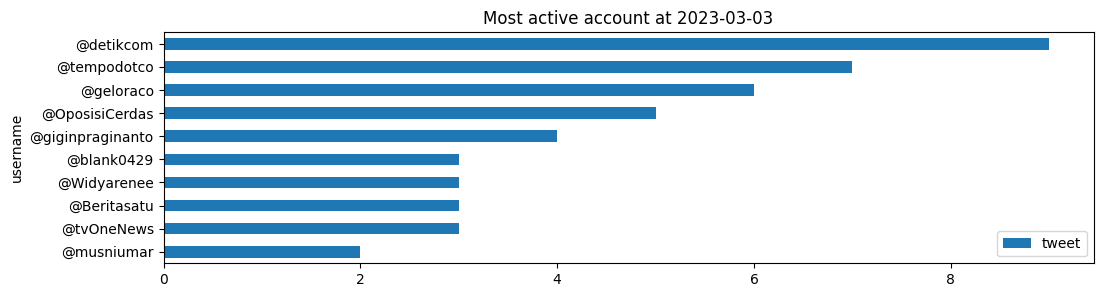

In [239]:
(df[peak_date].groupby(by='username')
              .agg(tweet=('url', 'size'))
              .sort_values(by='tweet', ascending=False)
              .head(10)
              .sort_values(by='tweet', ascending=True)
              .plot(kind='barh',
                    title="Most active account at 2023-03-03",
                    figsize=(12,3)))

## Most engaged account

<Axes: title={'center': 'Most engaged account'}, ylabel='username'>

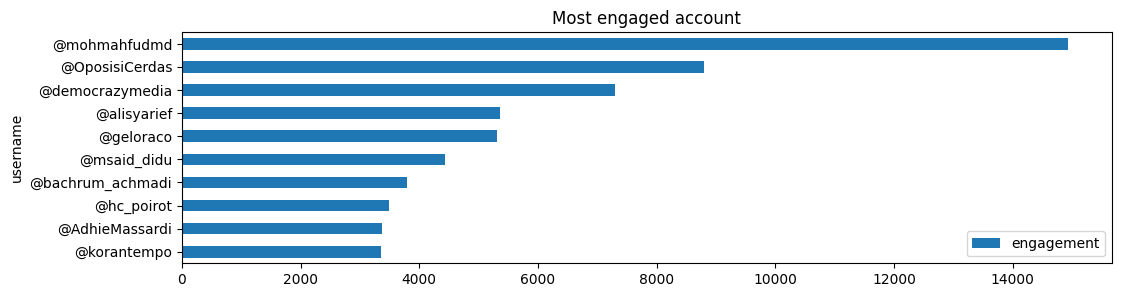

In [240]:
(df.groupby(by='username')
   .agg(engagement=('engagement', 'sum'))
   .sort_values(by='engagement', ascending=False)
   .head(10)
   .sort_values(by='engagement', ascending=True)
   .plot(kind='barh',
         title="Most engaged account",
         figsize=(12,3)))

<Axes: title={'center': 'Most engaged account at 2023-03-03'}, ylabel='username'>

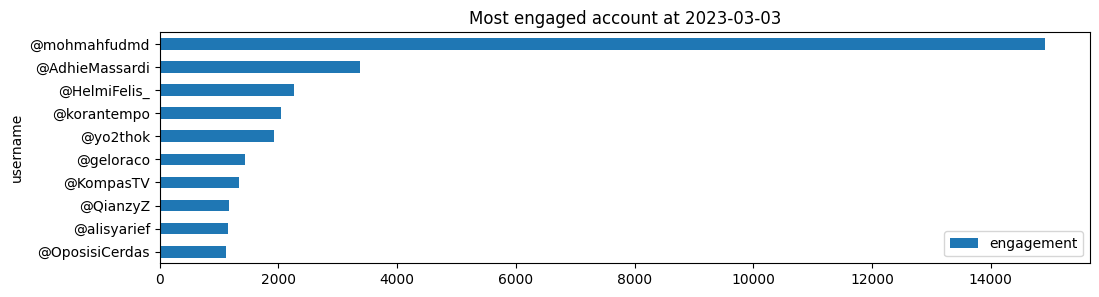

In [241]:
(df[peak_date].groupby(by='username')
              .agg(engagement=('engagement', 'sum'))
              .sort_values(by='engagement', ascending=False)
              .head(10)
              .sort_values(by='engagement', ascending=True)
              .plot(kind='barh',
                    title="Most engaged account at 2023-03-03",
                    figsize=(12,3)))

## Most engaged tweets

<Axes: title={'center': 'Most engaged tweets'}, ylabel='url'>

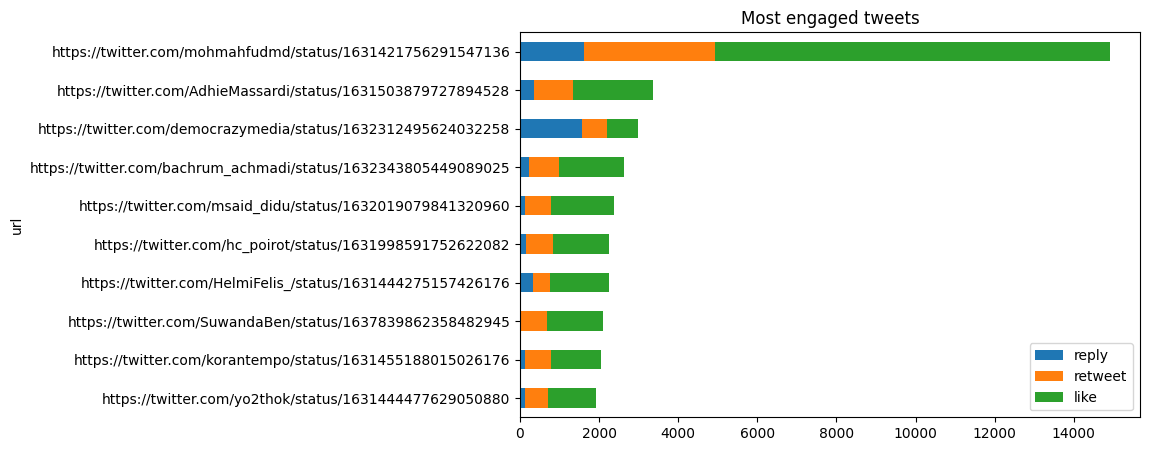

In [242]:
(df[['url', 'reply', 'retweet', 'like', 'engagement']].sort_values(by='engagement', ascending=False)
                                                      .head(10)
                                                      .sort_values(by='engagement', ascending=True)
                                                      .plot(kind='barh',
                                                            x='url',
                                                            y=['reply', 'retweet', 'like'],
                                                            figsize=(8,5),
                                                            title="Most engaged tweets",
                                                            stacked=True))

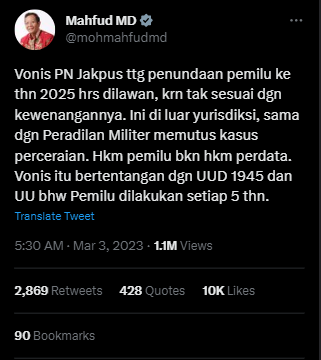
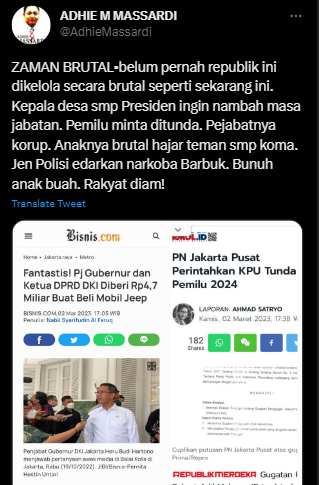
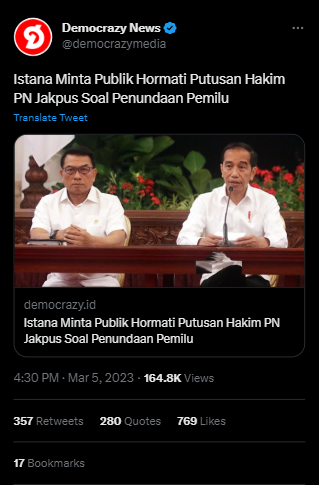

## Most frequent word

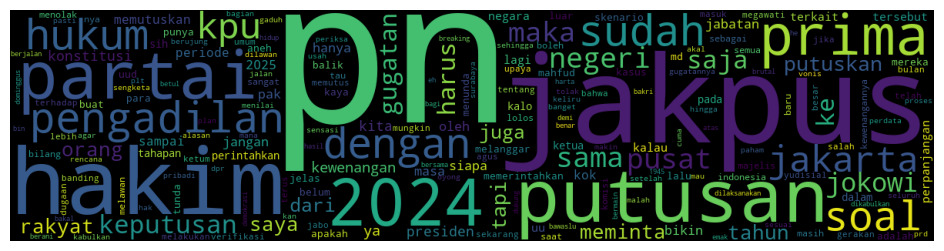

In [243]:
stopwords = ['pemilu', 'penundaan', 'ditunda']
stopwords.extend(['yang', 'yg', 'ini', 'dan', 'ada', 'akan', 'tidak', 'di', 'itu', 'bukan', 'karena', 'bisa', 'untuk', 'apa', 'tak', 'jadi', 'atau', 'enggak'])

cv_1gram = CountVectorizer(ngram_range=(1,1), stop_words=stopwords)
vectors_1gram = cv_1gram.fit_transform(df[peak_date]['text'])
freqs_1gram = vectors_1gram.toarray().sum(axis=0)
features_1gram = cv_1gram.get_feature_names_out()

wc_1gram = WordCloud(stopwords=stopwords, repeat=False, width=1200, height=300)
wcimg_1gram = wc_1gram.generate_from_frequencies({features_1gram[i]:freqs_1gram[i] for i in range(features_1gram.shape[0])})
plt.figure(figsize=(12,3))
plt.imshow(wcimg_1gram)
plt.axis('Off')
plt.show()



<Axes: ylabel='token'>

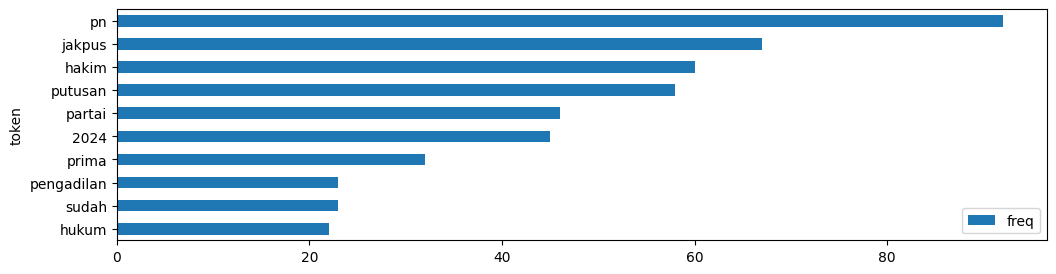

In [244]:
(pd.DataFrame({'token': cv_1gram.get_feature_names_out(), 'freq': freqs_1gram})
   .sort_values(by='freq', ascending=False)
   .head(10)
   .sort_values(by='freq', ascending=True)
   .plot(kind='barh', x='token', y='freq', figsize=(12,3)))

## Most frequent phrase

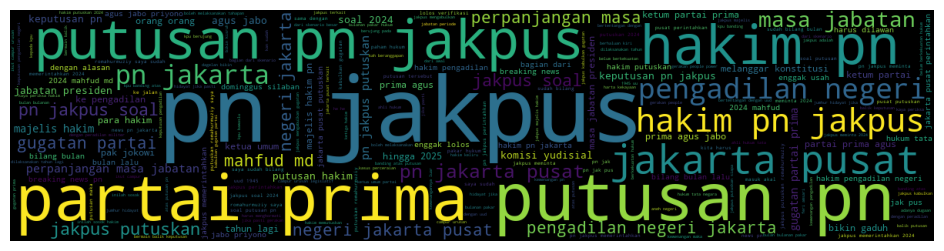

In [245]:
stopwords = ['pemilu', 'penundaan', 'ditunda']
stopwords.extend(['yang', 'yg', 'ini', 'dan', 'ada', 'akan', 'tidak', 'di', 'itu', 'bukan', 'karena', 'bisa', 'untuk', 'apa', 'tak', 'jadi', 'atau'])

cv_2gram = CountVectorizer(ngram_range=(2,3), stop_words=stopwords)
vectors_2gram = cv_2gram.fit_transform(df[peak_date]['text'])
freqs_2gram = vectors_2gram.toarray().sum(axis=0)
features_2gram = cv_2gram.get_feature_names_out()

wc_2gram = WordCloud(stopwords=stopwords, width=1200, height=300)
wcimg_2gram = wc_2gram.generate_from_frequencies({features_2gram[i]:freqs_2gram[i] for i in range(features_2gram.shape[0])})
plt.figure(figsize=(12,3))
plt.imshow(wcimg_2gram)
plt.axis('Off')
plt.show()

<Axes: ylabel='token'>

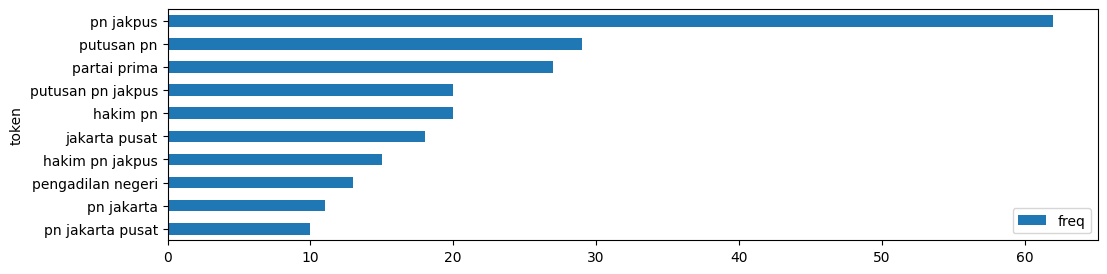

In [246]:
(pd.DataFrame({'token': features_2gram, 'freq': freqs_2gram})
   .sort_values(by='freq', ascending=False)
   .head(10)
   .sort_values(by='freq', ascending=True)
   .plot(kind='barh', x='token', y='freq', figsize=(12,3)))

## Most frequent hashtag

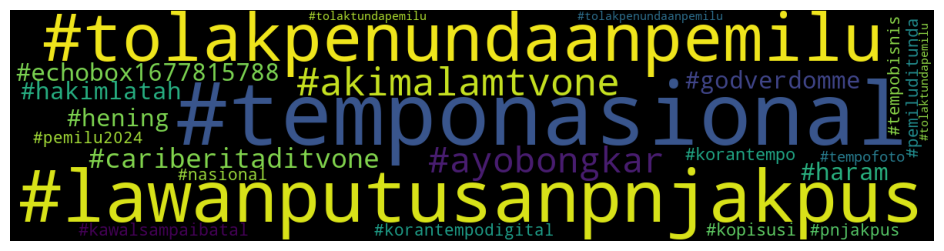

In [247]:
stopwords = ['pemilu', 'penundaan', 'ditunda']
stopwords.extend(['yang', 'yg', 'ini', 'dan', 'ada', 'akan', 'tidak', 'di', 'itu', 'bukan', 'karena', 'bisa', 'untuk', 'apa', 'tak', 'jadi', 'atau'])

cv_hashtag = CountVectorizer(ngram_range=(1,1), stop_words=stopwords, token_pattern=r"#[^#\=.]+")
vectors_hashtag = cv_hashtag.fit_transform(df[peak_date]['hashtag'].apply(lambda hashtag: ' '.join(hashtag) if hashtag else ''))
freqs_hashtag = vectors_hashtag.toarray().sum(axis=0)
features_hashtag = cv_hashtag.get_feature_names_out()

wc_hashtag = WordCloud(stopwords=stopwords, repeat=False, width=1200, height=300)
wcimg_hashtag = wc_hashtag.generate_from_frequencies({features_hashtag[i]:freqs_hashtag[i] for i in range(features_hashtag.shape[0])})
plt.figure(figsize=(12,3))
plt.imshow(wcimg_hashtag)
plt.axis('Off')
plt.show()

<Axes: ylabel='token'>

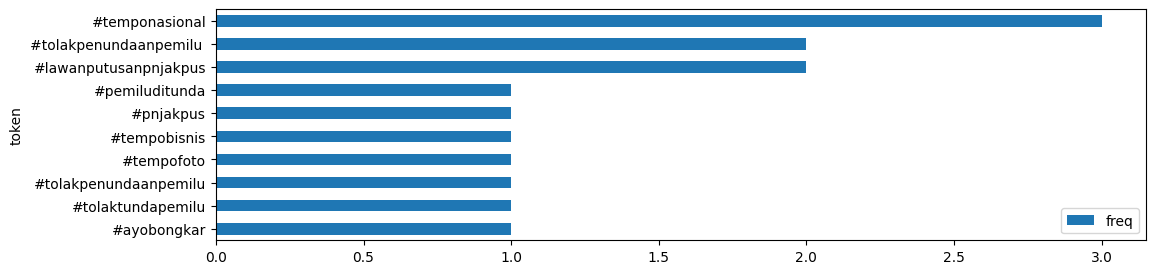

In [248]:
(pd.DataFrame({'token': features_hashtag, 'freq': freqs_hashtag})
   .sort_values(by='freq', ascending=False)
   .head(10)
   .sort_values(by='freq', ascending=True)
   .plot(kind='barh', x='token', y='freq', figsize=(12,3)))

# Sentiment analysis

### Task:
1. Load smsa dataset and do initial analysis
2. Do preprocessing
3. Modeling: choose best vectorizer and estimator
4. Predict the sentiment
5. Do data analysis

## 1 Load the dataset

In [249]:
# Website: https://indobenchmark.com
# Repository: https://github.com/IndoNLP/indonlu
#
# @inproceedings{wilie2020indonlu,
#   title={IndoNLU: Benchmark and Resources for Evaluating Indonesian Natural Language Understanding},
#   author={Bryan Wilie and Karissa Vincentio and Genta Indra Winata and Samuel Cahyawijaya and X. Li and Zhi Yuan Lim and S. Soleman and R. Mahendra and Pascale Fung and Syafri Bahar and A. Purwarianti},
#   booktitle={Proceedings of the 1st Conference of the Asia-Pacific Chapter of the Association for Computational Linguistics and the 10th International Joint Conference on Natural Language Processing},
#   year={2020}
# }

urls = {
    'train': 'https://raw.githubusercontent.com/IndoNLP/indonlu/master/dataset/smsa_doc-sentiment-prosa/train_preprocess.tsv',
    'valid': 'https://raw.githubusercontent.com/IndoNLP/indonlu/master/dataset/smsa_doc-sentiment-prosa/valid_preprocess.tsv',
    'test' : 'https://raw.githubusercontent.com/IndoNLP/indonlu/master/dataset/smsa_doc-sentiment-prosa/test_preprocess.tsv',
}

def read_tsv(url, name):
    return pd.read_csv(url, delimiter='\t', header=None, names=['text', 'label']).assign(type=name)

df_indonlu = pd.concat([ read_tsv(url, name) for name, url in urls.items() ])

### Dataset overview

In [250]:
df_indonlu.sample(10)

,text,label,type
7157,po ketiam terletak di jalan pasir kaliki sebel...,positive,train
1608,tidak berantakan,positive,train
2042,nikmati cicilan 0 % hingga 12 bulan untuk peme...,neutral,train
2410,tidak usah pencitraan . karena fitnah . demons...,negative,train
582,sejuk,positive,train
249,"makanan nya enak banget super deh , coba saja ...",positive,valid
7898,saya menambahkan video ke playlist origami shi...,neutral,train
7518,ekspresi setya novanto saat menjalani persidan...,neutral,train
5330,tempat nya agak terpencil dan agak susah menca...,positive,train
4352,paling malas kalau dikasih banyak tugas bikin ...,negative,train


In [251]:
df_indonlu.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12760 entries, 0 to 499
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    12760 non-null  object
 1   label   12760 non-null  object
 2   type    12760 non-null  object
dtypes: object(3)
memory usage: 398.8+ KB


### Train, valid, test

<Axes: title={'center': 'Train, valid, test'}, xlabel='type'>

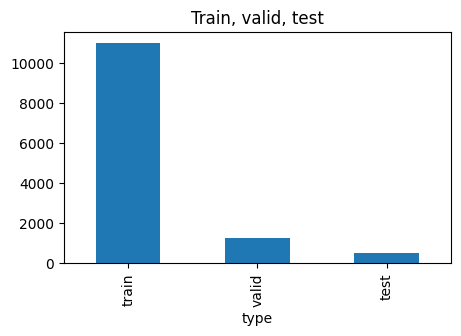

In [252]:
(df_indonlu['type'].value_counts()
                   .plot(kind='bar',
                         title="Train, valid, test",
                         figsize=(5,3)))

### Missing values

In [253]:
df_indonlu.isna().sum()

text     0
label    0
type     0
dtype: int64

### Label distribution

<Axes: title={'center': 'Label distribution'}, ylabel='count'>

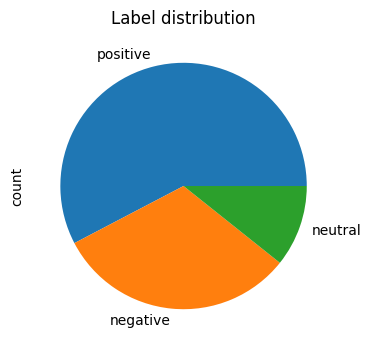

In [254]:
(df_indonlu['label'].value_counts()
                    .plot(kind='pie',
                          title="Label distribution",
                          figsize=(4,4)))

### Content length distribution

<Axes: title={'center': 'Content length distribution'}, ylabel='Frequency'>

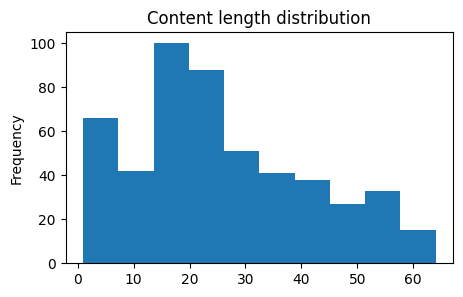

In [255]:
(df_indonlu['text'].str.len()
                   .value_counts()
                   .sort_values(ascending=False)
                   .plot(kind='hist',
                         title="Content length distribution",
                         figsize=(5,3)))

## 2 Preprocessing

In [256]:
df_indonlu['text_preprocessed'] = df_indonlu['text']

Keep original `text` for analysis purpose

### Text cleaning

In [257]:
def clean(text):
    # remove any number except year
    text = re.sub(r'\b(?!19[4-9]\d|20[0-3]\d|2040)\d+\b', ' ', text)
    # remove punctuations
    text = re.sub(f'[{string.punctuation}]+', ' ', text)
    # remove multi whitespace
    text = re.sub(r'\s+', ' ', text)
    # lower the case
    text = text.lower()
    # strip whitespace
    text = text.strip()
    
    return text

In [258]:
df_indonlu['text_preprocessed'] = df_indonlu['text_preprocessed'].apply(clean)

### Remove stopwords

In [259]:
stopwords = [
    'lah', 'kah', 'pun', 'ku', 'kau', 'mu', 'nya', 
    'kan', 'an', 'isasi', 'i', 'isme',
    'di', 'ke', 'se'
]

stopwords = list(set(stopwords))

def remove_stopwords(document):
    return ' '.join([
        word for word in document.split() if not word in stopwords
    ])

In [260]:
df_indonlu['text_preprocessed'] = df_indonlu['text_preprocessed'].apply(remove_stopwords)

## 3 Modeling

### Selecting ngram

Task: Generating token with diferent gram, and train it, then pick best accuracy score prediction to validation dataset

In [307]:
gs_vectorizers = GridSearchCV(estimator=Pipeline([('cv', CountVectorizer()),
                                                  ('lr', LogisticRegression(max_iter=1000))]), 
                              param_grid={'cv__ngram_range': [(1,1), (1,2), (1,3)],
                                          'cv__min_df': [1, 2, 5, 10],
                                          'cv__max_df': [1, 3000, 5000, 7000],
                                          'cv__max_features': [5000, 10000, 15000]}, 
                              scoring='f1_macro', cv=5, n_jobs=-1)

gs_vectorizers.fit(df_indonlu[df_indonlu['type'] == 'train']['text_preprocessed'], df_indonlu[df_indonlu['type'] == 'train']['label'])

df_vectorizers = pd.DataFrame(gs_vectorizers.cv_results_).sort_values(by=['mean_fit_time', 'mean_test_score'], ascending=[True, False])

e:\python\sentiment-analysis\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
135 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "e:\python\sentiment-analysis\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "e:\python\sentiment-analysis\lib\site-packages\sklearn\pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "e:\python\sentiment-analysis\lib\site-packages\sklearn\pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "e:\

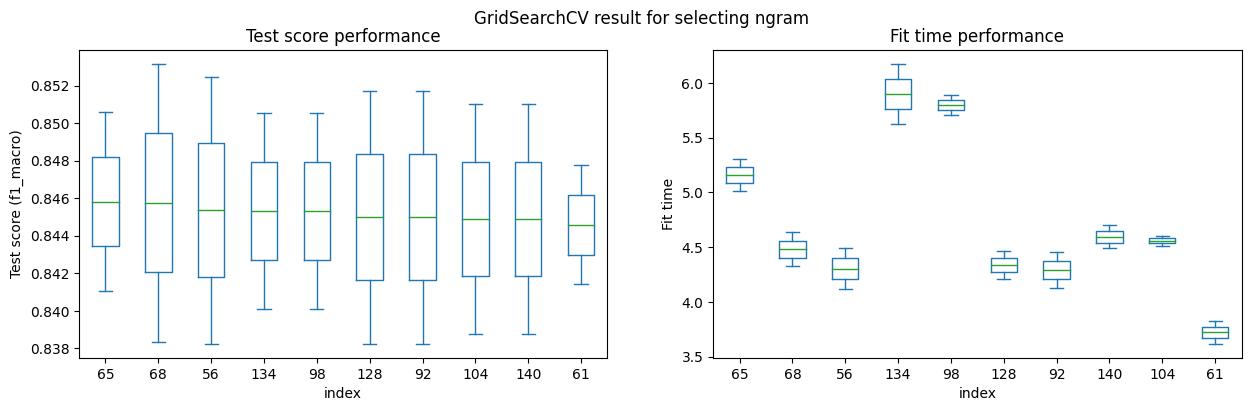

In [309]:
fig, ax = plt.subplots(1,2, figsize=(15,4))

fig.suptitle('GridSearchCV result for selecting ngram')

# Box plot of mean test score and std
(df_vectorizers.assign(min_test_score=df_vectorizers['mean_test_score'] - df_vectorizers['std_test_score'],
                       max_test_score=df_vectorizers['mean_test_score'] + df_vectorizers['std_test_score'])
               .sort_values(by='mean_test_score', ascending=False)
               .head(10)[['min_test_score', 'mean_test_score', 'max_test_score']]
               .T
               .plot(kind='box', 
                     xlabel='index', 
                     ylabel='Test score (f1_macro)', 
                     title='Test score performance',
                     ax=ax[0]))

# Box plot of mean fit time and std
(df_vectorizers.assign(min_fit_time=df_vectorizers['mean_fit_time'] - df_vectorizers['std_fit_time'],
                       max_fit_time=df_vectorizers['mean_fit_time'] + df_vectorizers['std_fit_time'])
               .sort_values(by='rank_test_score')
               .head(10)[['min_fit_time', 'mean_fit_time', 'max_fit_time']]
               .T
               .plot(kind='box', 
                     xlabel='index', 
                     ylabel='Fit time', 
                     title="Fit time performance", 
                     ax=ax[1]))

plt.show()

In [315]:
df_vectorizers.sort_values(by='rank_test_score').head(10)[['param_cv__ngram_range', 'param_cv__min_df', 'param_cv__max_df', 'param_cv__max_features', 'mean_test_score', 'mean_fit_time']].T

,65,68,56,134,98,128,92,140,104,61
param_cv__ngram_range,"(1, 3)","(1, 3)","(1, 3)","(1, 3)","(1, 3)","(1, 3)","(1, 3)","(1, 3)","(1, 3)","(1, 2)"
param_cv__min_df,2,5,5,1,1,5,5,5,5,1
param_cv__max_df,3000,3000,3000,7000,5000,7000,5000,7000,5000,3000
param_cv__max_features,15000,15000,10000,15000,15000,10000,10000,15000,15000,15000
mean_test_score,0.84581,0.845748,0.845362,0.845315,0.845315,0.844983,0.844983,0.844892,0.844892,0.844583
mean_fit_time,5.159285,4.481415,4.303676,5.89778,5.794387,4.335857,4.290731,4.594508,4.556988,3.721961


We select params with `index` = 65 as the best params, by considering it has similar mean_test_score with best mean_test_score and lowest fit_time also has most features (15.000) 

### Find baseline model using best ngram

In [316]:
X_train = df_indonlu[df_indonlu['type']=='train']['text_preprocessed']
y_train = df_indonlu[df_indonlu['type']=='train']['label']

cv = CountVectorizer(ngram_range=(1,3), min_df=5, max_df=3000, max_features=15000)
X_train = cv.fit_transform(df_indonlu[df_indonlu['type']=='train']['text_preprocessed'])
y_train = df_indonlu[df_indonlu['type']=='train']['label']

X_test = cv.transform(df_indonlu[df_indonlu['type']=='test']['text_preprocessed'])
y_test = df_indonlu[df_indonlu['type']=='test']['label']

models = [
    LogisticRegression(max_iter=1000),
    DecisionTreeClassifier(max_depth=1000),
    SVC(max_iter=10000),
]

result = []

for model in tqdm(models):
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    result.append({'model': model, 'f1_score': f1_score(y_test, y_pred, average='macro'), 'result': pd.Series(y_pred).value_counts().to_dict()})

100%|██████████| 3/3 [00:22<00:00,  7.51s/it]


In [317]:
pd.DataFrame(result)

,model,f1_score,result
0,LogisticRegression(max_iter=1000),0.752575,"{'negative': 256, 'positive': 195, 'neutral': 49}"
1,DecisionTreeClassifier(max_depth=1000),0.580930,"{'negative': 276, 'positive': 175, 'neutral': 49}"
2,SVC(max_iter=10000),0.659563,"{'negative': 318, 'positive': 153, 'neutral': 29}"


<Axes: title={'center': 'Train - Test'}, ylabel='model'>

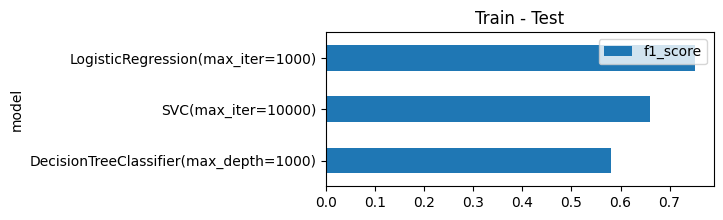

In [318]:
pd.DataFrame(result).sort_values(by='f1_score', ascending=True).plot(kind='barh', x='model', title="Train - Test", figsize=(5,2))

### Hyper parameter tuning

In [319]:
cv = CountVectorizer(ngram_range=(1,3), min_df=5, max_df=3000, max_features=15000)
X_train = cv.fit_transform(df_indonlu[df_indonlu['type']=='train']['text_preprocessed'])
y_train = df_indonlu[df_indonlu['type']=='train']['label']

gs = GridSearchCV(LogisticRegression(max_iter=1000, n_jobs=1),
                  {'C': [.1, 1, 10],
                   'multi_class': ['ovr', 'multinomial'],
                   'fit_intercept': [True, False]},
                  scoring='f1_macro', 
                  cv=5,
                  n_jobs=-1,
                  verbose=1)
gs.fit(X_train, y_train)

df_result = pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score')

Fitting 5 folds for each of 12 candidates, totalling 60 fits


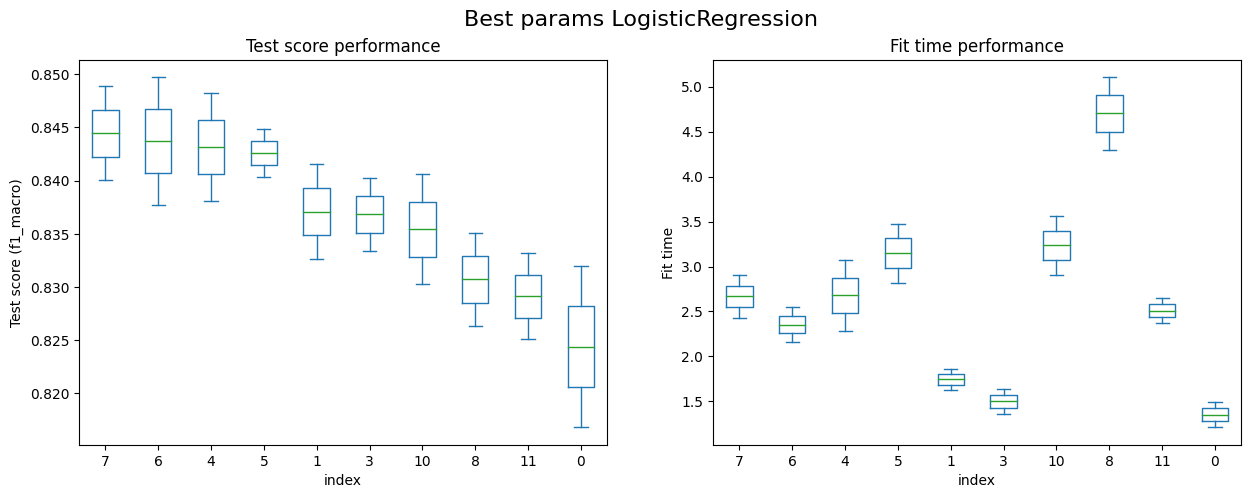

In [320]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
fig.suptitle('Best params LogisticRegression', fontsize=16)

# Box plot of mean test score and std
(df_result.assign(min_test_score=df_result['mean_test_score'] - df_result['std_test_score'],
                       max_test_score=df_result['mean_test_score'] + df_result['std_test_score'])
               .sort_values(by='mean_test_score', ascending=False)
               .head(10)[['min_test_score', 'mean_test_score', 'max_test_score']]
               .T
               .plot(kind='box', 
                     xlabel='index', 
                     ylabel='Test score (f1_macro)', 
                     title='Test score performance',
                     ax=ax[0]))

# Box plot of mean fit time and std
(df_result.assign(min_fit_time=df_result['mean_fit_time'] - df_result['std_fit_time'],
                       max_fit_time=df_result['mean_fit_time'] + df_result['std_fit_time'])
               .sort_values(by='rank_test_score')
               .head(10)[['min_fit_time', 'mean_fit_time', 'max_fit_time']]
               .T
               .plot(kind='box', 
                     xlabel='index', 
                     ylabel='Fit time', 
                     title="Fit time performance", 
                     ax=ax[1]))

plt.show()

In [327]:
df_result.sort_values(by='rank_test_score').head(10)[['param_C', 'param_multi_class', 'param_fit_intercept', 'mean_test_score', 'mean_fit_time']].T

,7,6,4,5,1,3,10,8,11,0
param_C,1,1,1,1,0.1,0.1,10,10,10,0.1
param_multi_class,multinomial,ovr,ovr,multinomial,multinomial,multinomial,ovr,ovr,multinomial,ovr
param_fit_intercept,False,False,True,True,True,False,False,True,False,True
mean_test_score,0.844455,0.843734,0.843181,0.842606,0.837077,0.83682,0.835429,0.830698,0.829122,0.824388
mean_fit_time,2.668238,2.353173,2.678369,3.144867,1.743924,1.501052,3.234043,4.702003,2.510714,1.351873


We select `index` = 7 as best parameters, since it has highest `mean_test_score` also low in deviation, and similar `mean_fit_time`

## 4 Sentiment prediction

In [331]:
X_train = df_indonlu[df_indonlu['type']=='train']['text_preprocessed']
y_train = df_indonlu[df_indonlu['type']=='train']['label']

# Add stopwords `pemilu` `penundaan` and `ditunda` since all document has it, and should be ignore
cv = CountVectorizer(ngram_range=(1,3), min_df=5, max_df=3000, max_features=15000, stop_words=['pemilu', 'penundaan', 'ditunda'])
X_train = cv.fit_transform(df_indonlu[df_indonlu['type']=='train']['text_preprocessed'])

lr = LogisticRegression(C=1, multi_class='multinomial', fit_intercept=False, n_jobs=-1)
lr.fit(X_train, y_train)

X_pred = cv.transform(df['text'])
y_pred = lr.predict(X_pred)

df['label'] = y_pred

## Result

### Label distribution

<Axes: title={'center': 'Predicted label distribution'}, ylabel='count'>

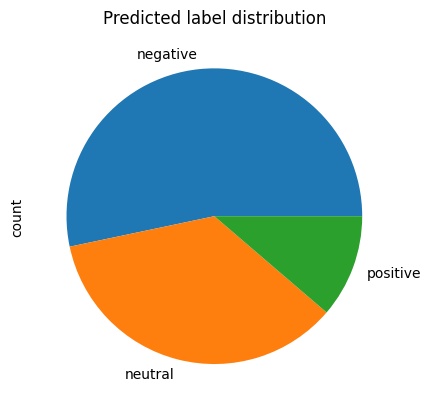

In [332]:
df['label'].value_counts().plot(kind='pie', title="Predicted label distribution")

Most sentiments are predicted as `negative`

In [353]:
def get_most_frequent_phrases(sentences):
    cv = CountVectorizer(ngram_range=(2,3), stop_words=['pemilu', 'penundaan', 'ditunda', 'yang', 'ada'])
    vc = cv.fit_transform(sentences)
    return (pd.DataFrame(vc.sum(axis=0), columns=cv.get_feature_names_out())
              .T
              .rename(columns={0:'freq'})
              .sort_values(by='freq', ascending=False))

### 'Negative labeled' wordcloud

In [363]:
most_frequent_negative_sentiment_phrases = get_most_frequent_phrases(df[df['label'] == 'negative']['text']).sort_values(by='freq', ascending=False)

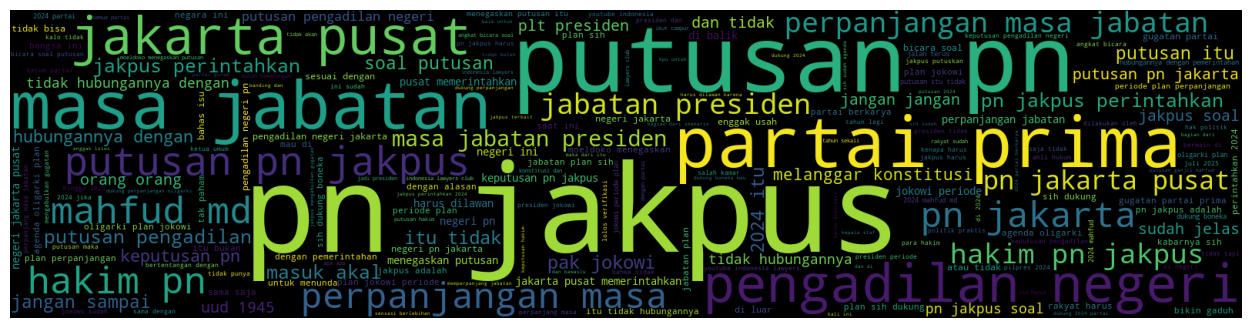

In [365]:
wc = WordCloud(collocations=True, width=1600, height=400)
im = wc.generate_from_frequencies(most_frequent_negative_sentiment_phrases.freq.to_dict())

plt.figure(figsize=(16, 4))
plt.imshow(im)
plt.axis('off')
plt.show()

<Axes: >

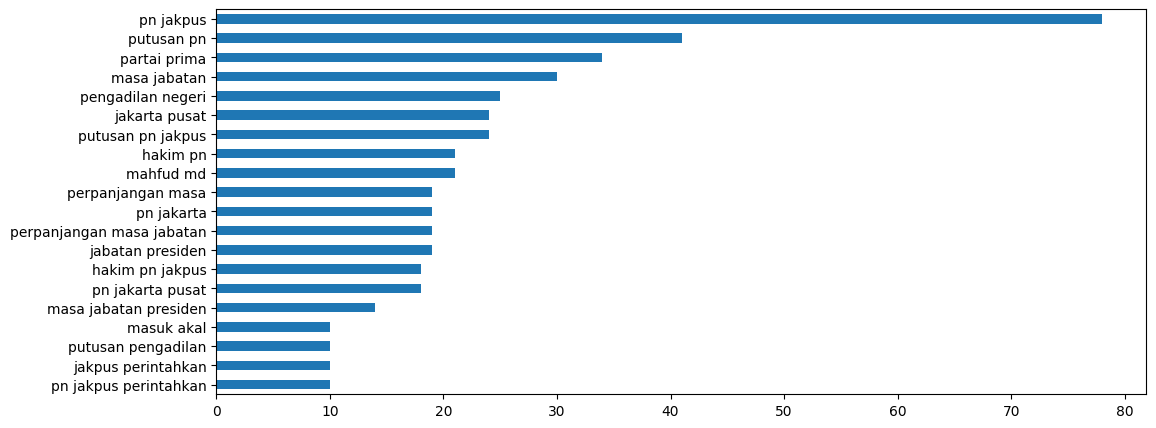

In [361]:
most_frequent_negative_sentiment_phrases.head(20).freq.sort_values().plot(kind='barh', figsize=(12,5))

* Kata-kata yang sering dibicarakan adalah terkait tentang (putusan) pn jakpus, masa jabatan (presiden), partai prima

### Most liked negative labeled tweet

In [335]:
for twit in df[df['label'] == 'negative'].sort_values(by='like', ascending=False).head()[['datetime', 'username', 'original_text', 'text']].values:
    print(twit[0], twit[1])
    print(twit[2])
    print()

2023-03-03 05:30:31+07:00 @mohmahfudmd
Vonis PN Jakpus ttg penundaan pemilu ke thn 2025 hrs dilawan, krn tak sesuai dgn kewenangannya. Ini di luar yurisdiksi, sama dgn Peradilan Militer memutus kasus perceraian. Hkm pemilu bkn hkm perdata. Vonis itu bertentangan dgn UUD 1945 dan UU bhw Pemilu dilakukan setiap 5 thn.

2023-03-03 10:56:51+07:00 @AdhieMassardi
ZAMAN BRUTAL▪︎belum pernah republik ini dikelola secara brutal seperti sekarang ini. Kepala desa smp Presiden ingin nambah masa jabatan. Pemilu minta ditunda. Pejabatnya korup. Anaknya brutal hajar teman smp koma. Jen Polisi edarkan narkoba Barbuk. Bunuh anak buah. Rakyat diam!

2023-03-05 18:34:25+07:00 @bachrum_achmadi
Inilah para bpk bangsa yg pernah wacanakan penundaan pemilu.

Para bpk bangsa ini mengajak rakyat u/ membegal konstitusi! 

2023-03-03 07:00:00+07:00 @HelmiFelis_
Jadi gini, yang menggugat dan menang sehingga Pemilu ditunda itu Partai PRIMA

Partai ini didirikan oleh orang-orang yang sebelumnya PRD

PRD berhaluan ki

* 2 dari 5 tweet yang paling disukai berkaitan dengan konstitusi, yang artinya penundaan pemilu (melalui putusan pn jakpus) adalah berlawanan dengan undang-undang
* 1 tweet menduga penundaan pemilu karena menginginkan penambahan masa jabatan kepresidenan
* 1 tweet mencurigai partai prima selaku penggugat di pengadilan adalah berhaluan kiri (komunis)
* 1 tweet mengungkapkan ketidakpercayaan terhadap figur politik

#### Negative sentiment hashtags

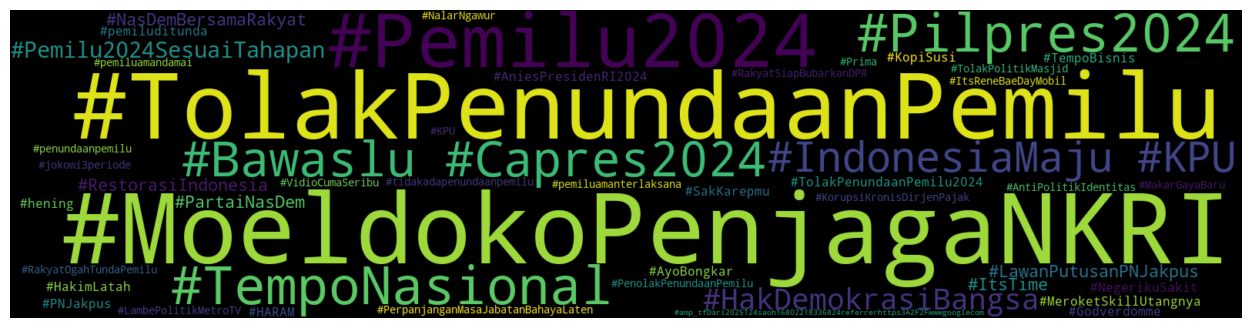

In [336]:
wc = WordCloud(collocations=True, width=1600, height=400, regexp=r'#[\w\d]+', repeat=False, prefer_horizontal=True)

negative_labeled_mask = ((df['hashtag'].notna()) & (df['label'] == 'negative'))
negative_labeled_hashtags = df[negative_labeled_mask]['hashtag'].apply(np.unique).values
negative_labeled_hashtags = np.concatenate(negative_labeled_hashtags)
negative_labeled_hashtags = [hashtag.strip() for hashtag in negative_labeled_hashtags if len(hashtag) < 100]

plt.figure(figsize=(16,4))
plt.imshow(wc.generate(' '.join(negative_labeled_hashtags)), interpolation='bilinear')
plt.axis('off')
plt.show()

<Axes: title={'center': 'Most popular hashtag'}, ylabel='hashtag'>

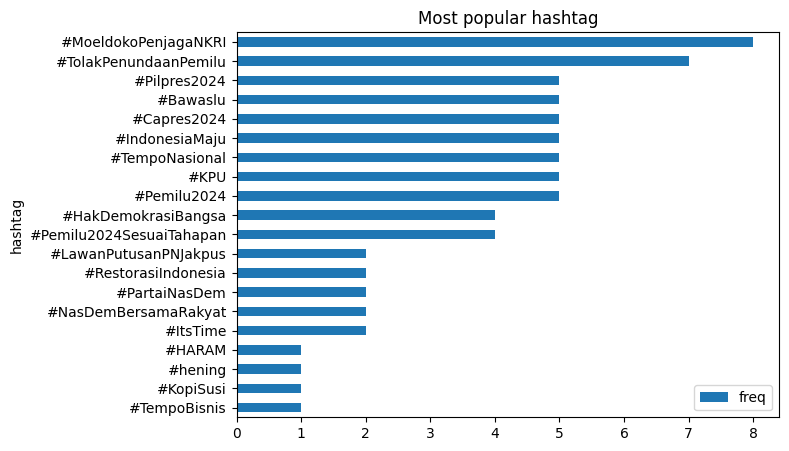

In [337]:
hashtag_dict = {}

for hashtag in negative_labeled_hashtags:
    hashtag_dict[hashtag] = hashtag_dict.get(hashtag, 0) + 1

(pd.DataFrame(hashtag_dict.items(), columns=['hashtag', 'freq'])
   .set_index('hashtag')
   .sort_values(by='freq', ascending=True)
   .tail(20)
   .plot(kind='barh', figsize=(7,5), title="Most popular hashtag"))

* Muncul beberapa hashtag yang tidak berhubungan langsung dengan isu, dengan jumlah cukup signifikan